# Barcoded-subamplicon sequencing of domain III of the E protein of ZIKV Natal strain
This iPython notebook analyzes barcoded-subamplicon sequencing of a mutant library of the E protein (domain III) of ZIKV Natal strain.
Data and experimental description provided by Yin Xiang Setoh and [Alexander Khromykh](https://staff.scmb.uq.edu.au/staff/alexander-khromykh); analysis by Jesse Bloom.

## Import the Python modules and check on the necessary programs
The analysis uses `dms_tools`, which can be [installed as described here](http://jbloomlab.github.io/dms_tools/installation.html).

In [1]:
# import Python modules
import os
import re
import glob
import Bio.SeqIO 
from pymodules.utils import showPDF

print("Using the following version of dms_tools:")
!dms_barcodedsubamplicons --version

Using the following version of dms_tools:
dms_barcodedsubamplicons 1.2.0


## Reference sequence and the subamplicon alignment specs
Yin provided the following schematic of the sequencing:

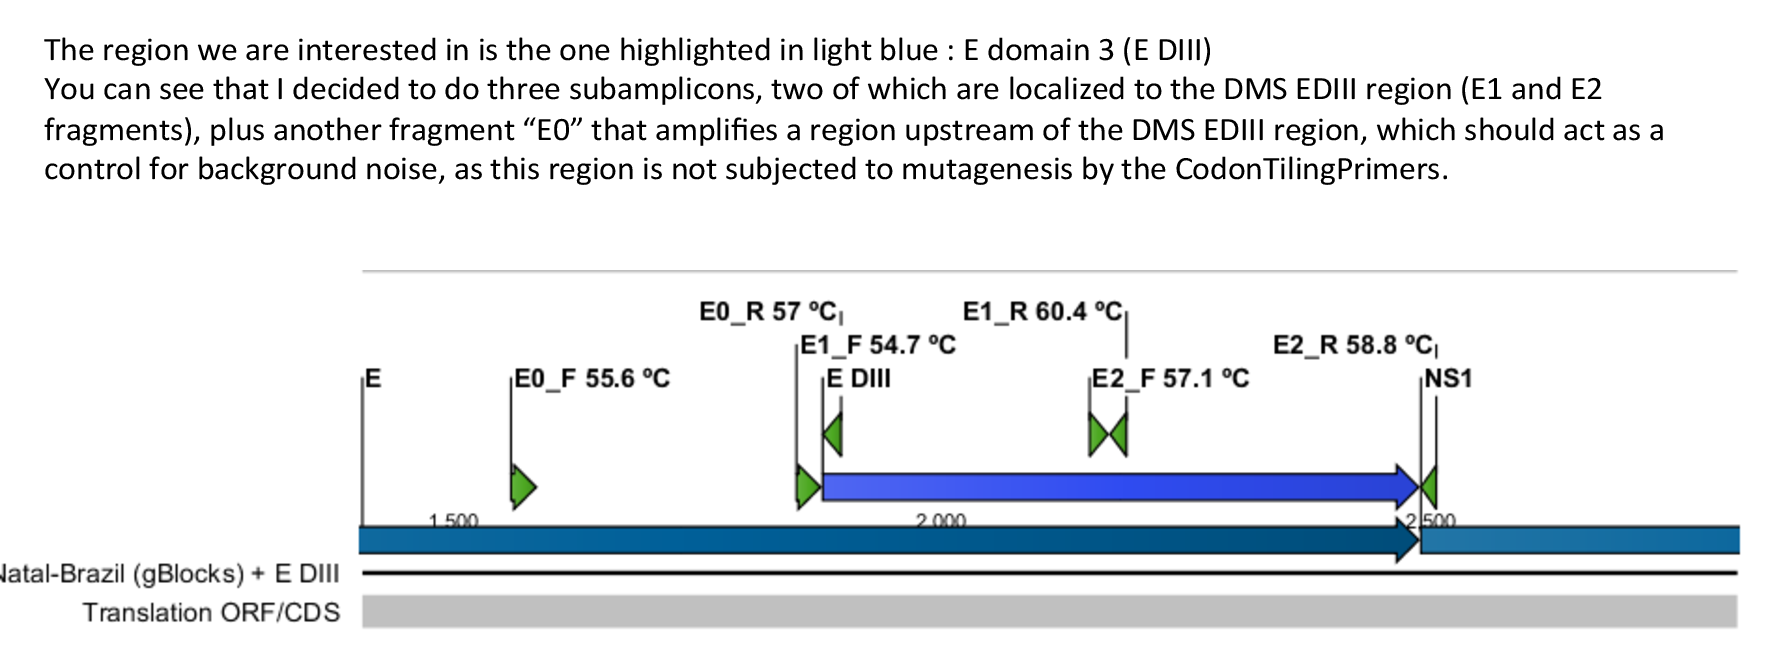

In [2]:
showPDF('data/images/ZIKV_E_DIII.pdf')

The reference sequence for the E protein domain III was provided by Yin.
Despite the fact that the file is named for domain III, it appears that this reference sequence actually spans from the beginning of the _E0\_F_ primer indicated in the schematic above, and so is really the domain III plus some upstream sequence.

We confirm that this is indeed a valid coding sequence.

In [3]:
refseqfile = './data/seqs/NatalEDIII.fa'
refseq = Bio.SeqIO.read(refseqfile, 'fasta').seq.upper()
print("Read reference sequence of {0} nt from {1}".format(len(refseq), refseqfile))
refprot = refseq.translate(to_stop=True)
assert len(refprot) == len(refseq) / 3., "Not a valid protein coding sequence"
print("This sequence encodes a protein of {0} amino acids".format(len(refprot)))

Read reference sequence of 903 nt from ./data/seqs/NatalEDIII.fa
This sequence encodes a protein of 301 amino acids


Yin also provided alignment specs for her three subamplicons, which she terms _E0_, _E1_, and _E2_.

Recall that for [dms_barcodedsubamplicons](http://jbloomlab.github.io/dms_tools/dms_barcodedsubamplicons.html), the alignment specs are `REFSEQSTART,REFSEQEND,R1START,R2START`, where the first two numbers indicate the start and end of the subamplicon in the reference sequence, and the next two numbers indicate first nucleotide that we consider in R1 and R2.

The alignment specs from Yin are as follows:

In [4]:
alignspecs = {
        'E0':'1,291,37,30',
        'E1':'292,585,36,28',
        'E2':'586,903,30,27',
        }

Every oligo should begin (and end) on a codon. Check that this is true:

In [5]:
for (subamplicon, spec) in alignspecs.items():
    (refseqstart, refseqend, r1start, r2start) = map(int, spec.split(','))
    if refseqstart % 3 != 1:
        print("subamplicon {0} does not begin on a codon")

Good, every subamplicon begins on a codon.

Yin also provided her primer sequences for PCR 1, which are defined below for each subamplicon.
The primers are named for the subamplicon and forward (_F_) or reverse (_R_):

In [6]:
primers = {
        'E0_F':'CTTTCCCTACACGACGCTCTTCCGATCTNNNNNNNNaggccttgacttttcagatttgtattac',
        'E0_R':'GGAGTTCAGACGTGTGCTCTTCCGATCTNNNNNNNNcaaggagtatgacacgccctt',
        'E1_F':'CTTTCCCTACACGACGCTCTTCCGATCTNNNNNNNNcgcctgaaaatggataaacttagattg',
        'E1_R':'GGAGTTCAGACGTGTGCTCTTCCGATCTNNNNNNNNtgccactcctgtgccagtg',
        'E2_F':'CTTTCCCTACACGACGCTCTTCCGATCTNNNNNNNNggggagaagaagatcacccac',
        'E2_R':'GGAGTTCAGACGTGTGCTCTTCCGATCTNNNNNNNNcaccgagcaccccacatc',
        }
barcodelength = 8 # length of barcode in each primer

We check and make sure that these primers and the alignspecs match up with the gene sequence as expected (this is a sanity check):

In [7]:
for (subamplicon, specs) in alignspecs.items():
    (refseqstart, refseqend, r1start, r2start) = map(int, specs.split(','))
    for (orientation, start) in [('F', r1start), ('R', r2start)]:
        primer = primers['{0}_{1}'.format(subamplicon, orientation)]
        # must add one below since Python uses 0-start indexing and alignspecs use 1 indexing
        assert primer[-start + 1 : -start + barcodelength + 1] == 'N' * barcodelength,\
                "Did not find barcode immediately upstream of primer binding site"
        overlap = primer[-start + barcodelength + 1 : ].upper()
        assert len(overlap) + barcodelength == start - 1
        if orientation == 'F':
            assert (overlap == refseq[refseqstart - len(overlap) - 1 : refseqstart - 1]) or (refseqstart <= 1),\
                    "primer did not overlap gene as expected"
        else:
            assert orientation == 'R'
            overlap = str(Bio.Seq.Seq(overlap).reverse_complement())
            x = refseq[refseqend - 2 : refseqend + len(overlap) - 2]

Everything passes, so it looks like the alignment specs from Yin are pretty much correct except for the issue associated with not beginning / ending on codons.

## Perform the subamplicon alignment and mutation calling
First, looking at the R2 reads manually reveals that they **all** start with the 10-nucleotide sequence `ATTCTTTCCC` before they have the barcode and the overlap with the gene. These initial 10-nucleotides must be some adaptor that was not trimmed. So before doing further analyses, we need to trim the first 10 nucleotides off all R2 sequences (the R1 sequences seem fine).

This 10 nucleotide sequence is **not** usually present when we do our runs, and I think it is possibly because the adaptors aren't trimmed? It would probably be OK to have your Genomics Core trim adaptors depending on how they do it, as what we add for the barcoded subamplicon sequencing may not be considered an adaptor in the Illumina trimming pipeline. But just trimming them manually here as done below also works fine.

We do this trimming using [fastx_trimmer](http://hannonlab.cshl.edu/fastx_toolkit/commandline.html).

In [8]:
# define names of files with FASTQ reads
r1file = 'data/fastq/J999_S90_L001_R1_001.fastq.gz'
r2file = r1file.replace('R1', 'R2')

# now make trimmed files
trimmed_r1file = r1file # no trimming for R1
trimmed_r2file = '{0}/trimmed_{1}'.format(os.path.dirname(r2file), os.path.basename(r2file))
if os.path.isfile(trimmed_r2file):
    print("Trimmed R2 file {0} already exists".format(trimmed_r2file))
else:
    print("Creating trimmed R2 file {0}".format(trimmed_r2file))
    !gunzip -k {r2file} && fastx_trimmer -i {unzipped_r2file} -o {trimmed_r2file} -z -f 11 && rm {unzipped_r2file}
assert os.path.isfile(trimmed_r2file)

Trimmed R2 file data/fastq/trimmed_J999_S90_L001_R2_001.fastq.gz already exists


Now we use [dms_barcodedsubamplicons](http://jbloomlab.github.io/dms_tools/dms_barcodedsubamplicons.html) to align the reads. 

The reads appear to be paired end 300-nucleotide. These are longer than needed, and probably have low quality at the ends. So we will trim them down to shorter lengths, making R1 a bit longer than R2 as it is usually higher quality. It appears that the longest that we actually need is 291 + 37 + 30 + 8 + 8 = 374, so we'll trim R1 to 200 nt and R2 to 180 nt.

This is an important experimental point, **you can probably save money by doing somewhat shorter reads such as 2 X 225 nt if your Genomics Core charges less for those.** There is no need to do shorter reads (the longer ones work fine as we can trim then), but depending on how they charge per length you may be doing more expensive sequencing than needed.

In [9]:
resultsdir = './results/'
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
aligndir = os.path.join(resultsdir, 'alignments')
if not os.path.isdir(aligndir):
    os.mkdir(aligndir) 

print("Performing analysis with:")
!dms_barcodedsubamplicons --version

outprefix = os.path.join(aligndir, 'E_DIII_mutlib')
print("\nOutput from dms_barcodedsubamplicons will have prefix {0}".format(outprefix))
countsfile = '{0}counts.txt'.format(outprefix) # name of created codon counts file

if os.path.isfile(countsfile):
    print("Output from dms_barcodesubamplicons already exists")
else:
    print("Runnding dms_barcodedsubamplicons...")
    log = !dms_barcodedsubamplicons {outprefix} {refseqfile} {trimmed_r1file} {trimmed_r2file} \
            {' '.join(alignspecs.values())} --barcodelength {barcodelength} \
            --R1trimlength 200 --R2trimlength 180
assert os.path.isfile(countsfile)   

Performing analysis with:
dms_barcodedsubamplicons 1.2.0

Output from dms_barcodedsubamplicons will have prefix ./results/alignments/E_DIII_mutlib
Output from dms_barcodesubamplicons already exists


Now we use [dms_summarizealignments](http://jbloomlab.github.io/dms_tools/dms_summarizealignments.html#dms-summarizealignments) to plot some summaries of the results. This makes some plots that we subsequently display below.

Note that many of the plots look a bit goofy because they are really designed to show data for multiple samples rather than just one, but you can still clearly see the results.

In [10]:
summaryoutprefix = os.path.join(aligndir, 'summary_')
print("Creating alignment summaries with prefix {0}".format(summaryoutprefix))

log = !dms_summarizealignments {summaryoutprefix} barcodedsubamplicons {outprefix},E-DIII-mutlib

Creating alignment summaries with prefix ./results/alignments/summary_


These first two plots show that the vast majority of the reads were of high quality and properly barcoded, and that a good fraction (at least half) could be subassembled and aligned. Most of the ones that could not be subassembled simply only had one read, which is expected since the depth was only about 2-3 times higher than the number of barcodes.

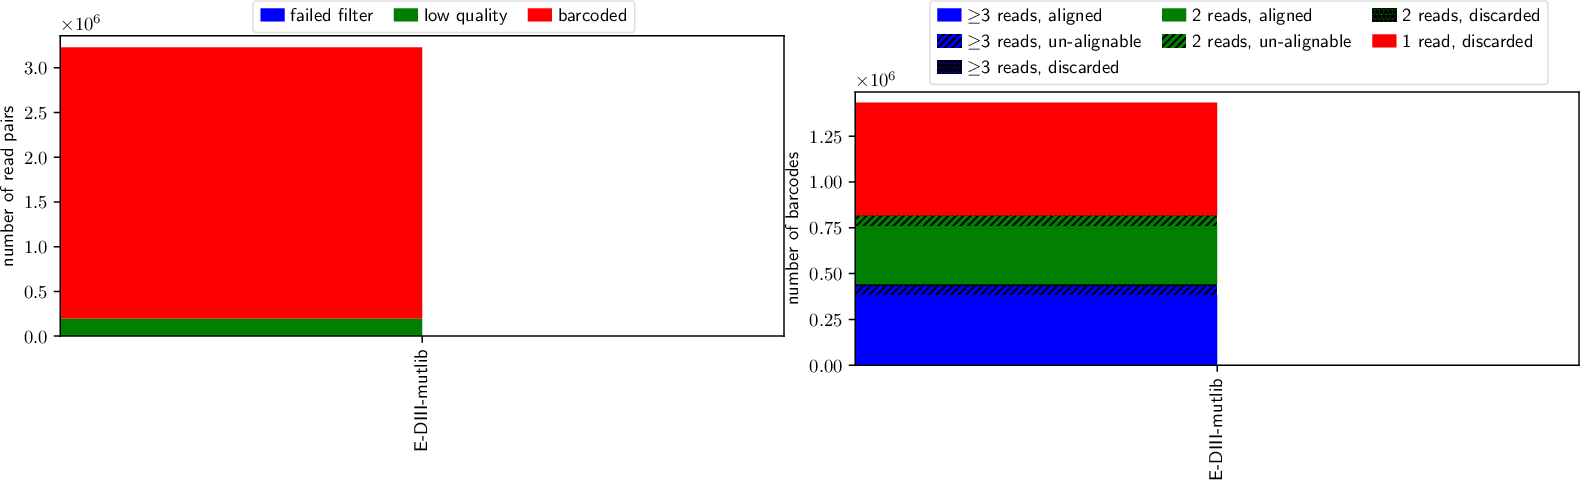

In [11]:
showPDF(['{0}{1}.pdf'.format(summaryoutprefix, suffix) for suffix in ['reads', 'barcodes']])

The next plot shows the depth along the gene (for each subamplicon). The depth is fairly uniform, ranging from about 2e5 to 3e5 per site. This is probably adequate for most experimental goals.

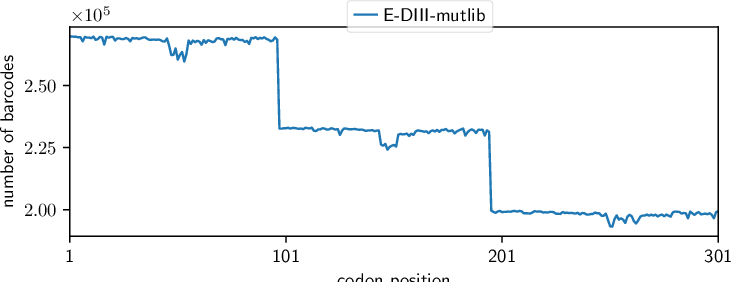

In [12]:
showPDF('{0}depth.pdf'.format(summaryoutprefix))

Now we look at the mutation frequency across the gene. As expected, the mutation depth is very low at the first subamplicon, which was not mutagenized. The mutation rate appears to fluctuate between 0.01 and 0.06 for the other sites. This corresponds to about 2-4 codon mutations per variant in the E-DIII region. This is perhaps a bit higher than desired, but seems perhaps workable. The fluctations across sites is something we've seen before in other genes, and can be corrected for in the analysis.

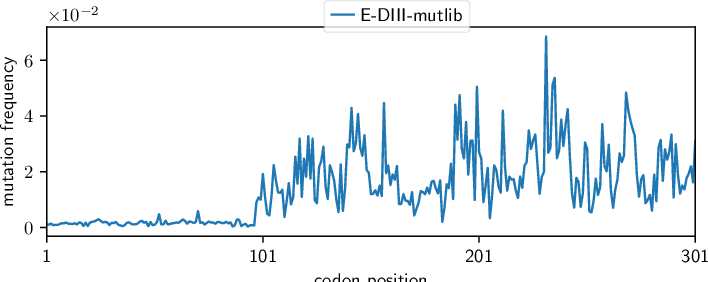

In [13]:
showPDF('{0}mutdepth.pdf'.format(summaryoutprefix))

Now we plot the average per-codon mutation frequency across the whole region. We can see that this is about 0.012. Keepin in mind that this includes the 1/3 of the gene that was not mutagenized, this corresponds to about 0.018 for the 200 mutagenized codons. This indeed implies a per-codon mutation rate of 3-4, which is pretty high...

We can see that there is a large pre-ponderance of 1-nucleotide mutations, larger than we typically get. But there are also multi-nucleotide codon mutations. There is not any substantial pre-ponderance of any one nucleotide mutation type, which is good.


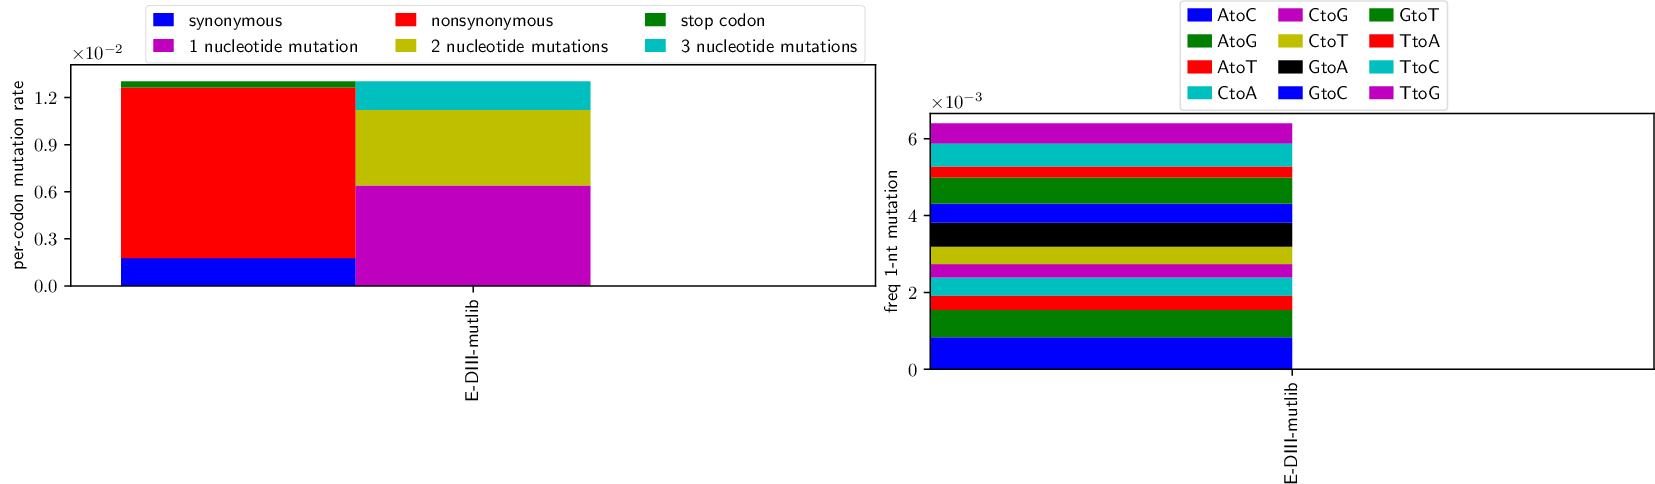

In [14]:
showPDF(['{0}{1}.pdf'.format(summaryoutprefix, suffix) for suffix in ['mutfreqs', 'singlemuttypes']])

Finally, we look at how often we observe each type of mutation. We expect to see about 2/3 of the possible codon mutations (since we mutagenized 2/3 of the gene), and that is about what we see when looking at all mutations. So the mutations are probably pretty well represented in the library.

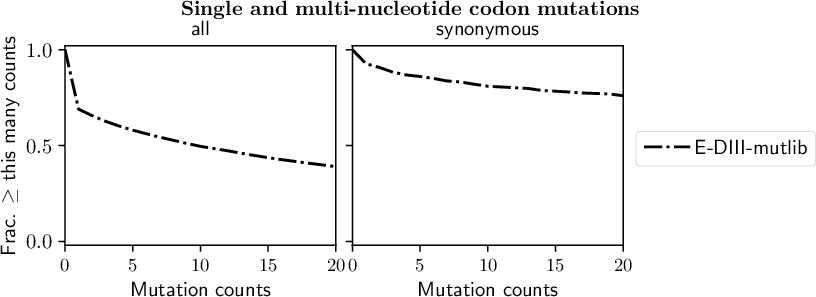

In [15]:
showPDF('{0}mutcounts_all.pdf'.format(summaryoutprefix))

## Overall conclusions
Here are some summary conclusions:

1. The barcoded subamplicon sequencing worked well.

2. You can potentially do shorter reads, such as 2 X 225 nt for these subamplicons. If your core says that is cheaper, I would suggest it. If there is no price difference, then you might as well keep doing the longer reads and we can just trim them.

3. The mutation rate is pretty high: 3-4 codon mutations per gene. This is probably workable, but you might get better data if you had it more like 1.5 mutations per gene as it would be easier to separate the effects of multiple mutations. So if you did two rounds of mutagenesis, you could consider going back and doing just one to get a lower mutation rate. But what you have will work, just not as well...

4. For future runs, definitely include sequencing of a wildtype gene (rather than just an unmutated subamplicon) as a control.